In [848]:
import os
import sys
import importlib
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn


import requests
from bs4 import BeautifulSoup
from selenium import webdriver

import redfin
import homepricemodels

importlib.reload(redfin)
importlib.reload(homepricemodels)



pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)



In [844]:
!pwd
!ls


/Users/timcodes/ds/metis/metisgh/02_Luther/Luther
LICENSE                         geckodriver.log
README.md                       homepricemodels.py
__pycache__                     pickles
explore_linear_regression.ipynb redfin.py
explore_luther.ipynb            redfin_2018-04-18-08-51-54.csv


In [860]:
all_home_stats = redfin.load_all_home_stats()

df_clean = redfin.clean_home_stats_df(all_home_stats)
df = df_clean.copy()

In [861]:
df['Year'] = home_stats_df['Last Sold'].map(lambda s: s.year)
home_stats_df.head(50)

,APN,Baths,Beds,County,Finished Sq. Ft.,Last Sold,Lot Size,Sales Price,Stories,Style,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Zip Code,rURL,Lot Size Sq. Ft.,Year
0,022180008,nan,nan,Kings County,3360.0,2017-08-02,"1,627 Sq. Ft.",1550000.0,3.0,Multi-Family (2-4 Unit),3360.0,nan,1899.0,1899.0,11211,/NY/Unknown/645-Bedford-Ave-11211/home/40736142,1627.0,2017
2,4024031032,1.0,2.0,Los Angeles County,864.0,2017-06-02,"3,431 Sq. Ft.",475000.0,1.0,Single Family Residential,864.0,nan,1926.0,1926.0,90301,/CA/Inglewood/110-E-Hardy-St-90301/home/6459725,3431.0,2017
3,4401029055,2.0,1.0,Los Angeles County,1072.0,2015-08-20,—,555500.0,nan,Condo/Co-op,1072.0,nan,1972.0,1976.0,90049,/CA/Los-Angeles/530-S-Barrington-Ave-90049/uni...,nan,2015
4,4021005021,2.0,2.0,Los Angeles County,1142.0,2018-04-11,—,294000.0,nan,Condo/Co-op,1142.0,nan,1970.0,1970.0,90301,/CA/Inglewood/526-E-Queen-St-90301/unit-3/home...,nan,2018
5,4022003008,2.0,5.0,Los Angeles County,1534.0,2016-05-19,"5,806 Sq. Ft.",350000.0,nan,Multi-Family (2-4 Unit),1534.0,nan,1955.0,nan,90301,/CA/Inglewood/710-S-Ash-Ave-90301/home/6453009,5806.0,2016
6,4277019013,2.0,3.0,Los Angeles County,1700.0,2015-07-21,"6,096 Sq. Ft.",2285000.0,1.0,Single Family Residential,1700.0,nan,1941.0,1985.0,90403,/CA/Santa-Monica/1020-25th-St-90403/home/6769299,6096.0,2015
7,3596039,3.0,4.0,San Francisco County,2095.0,2015-08-06,"1,873 Sq. Ft.",2100000.0,3.0,Single Family Residential,2095.0,nan,1906.0,nan,94110,/CA/San-Francisco/232-San-Carlos-St-94110/home...,1873.0,2015
8,048626200702,2.0,4.0,Alameda County,2193.0,2017-05-10,0.91 Acres,1100000.0,1.0,Single Family Residential,2193.0,nan,1959.0,1960.0,94605,/CA/Oakland/4235-Bemis-St-94605/home/1287711,39639.6,2017
9,048E733501203,3.0,4.0,Alameda County,2534.0,2015-10-14,"7,848 Sq. Ft.",1375000.0,3.0,Single Family Residential,2534.0,nan,1964.0,1966.0,94611-2338,/CA/Oakland/6609-Colton-Blvd-94611/home/1533713,7848.0,2015
10,064080009,2.0,3.0,Sonoma County,1826.0,2018-02-05,1.48 Acres,985000.0,2.0,Single Family Residential,1826.0,nan,1976.0,2005.0,95476,/CA/Sonoma/18970-Sweet-William-Ct-95476/home/2...,64468.8,2018


In [850]:
df['Month'].value_counts(sort=True)

6     443
3     405
7     391
5     388
8     379
10    356
11    350
9     342
12    327
4     311
2     273
1     271
Name: Month, dtype: int64

In [859]:
df.groupby(['Zip Code','Year']).median()

Baths  Beds  Sales Price  Stories  Total Sq. Ft.  Year Built  \
Zip Code Year                                                                 
10024    2015    nan   nan    1130000.0     12.0         1190.0      1911.0   
         2016    nan   nan    1697500.0     12.0         1101.0      1920.0   
         2017    nan   nan    1945000.0     12.0         1198.0      1920.0   
         2018    nan   nan    1507500.0     12.0         1003.0      1920.0   
11211    2015    nan   nan    1067326.5      4.0          974.5      2005.0   
         2016    nan   nan     962500.0      4.5         1099.0      1978.5   
         2017    nan   nan    1032549.5      4.0         1266.5      1915.0   
         2018    nan   nan    1545762.0      4.0         2137.5      1992.0   
48503    2015    1.5   3.0      24800.0      2.0         1869.0      1948.0   
         2016    1.5   3.0      30500.0      2.0         2030.0      1939.5   
         2017    1.5   3.0      32150.0      2.0         1787.0      1942.0   
         2018    1.5   3.0      29500.0      2.0         1960.0      1941.0   
90049    2015    3.0   3.0    1625000.0      1.0         2145.0      1969.5   
         2016    3.0   3.0    1623000.0      1.0         2141.0      1967.5   
         2017    3.0   4.0    2995000.0      1.0         2835.0      1963.0   
         2018    2.0   2.0     850500.0      nan         1408.0      1996.0   
90292    2015    2.0   2.0     905000.0      1.0         1645.5      1979.5   
         2016    2.0   2.0     913500.0      1.0         1630.0      1980.0   
         2017    2.0   2.0     920000.0      2.0         1582.0      1978.0   
90301    2015    2.0   2.0     322000.0      1.0         1230.5      1959.0   
         2016    2.0   2.0     382000.0      1.0         1226.0      1952.0   
         2017    2.0   2.0     413750.0      1.0         1070.0      1959.0   
         2018    2.0   2.0     440500.0      1.0         1158.5      1951.5   
90403    2015    2.0   2.0    1532500.0      1.0         1494.0      1974.0   
         2016    3.0   2.0    1530000.0      1.0         1713.0      1974.0   
         2017    3.0   2.0    1365000.0      1.0         1575.0      1972.5   
         2018    2.0   2.0    1355000.0      1.0         1503.0      1972.5   
94110    2015    2.0   3.0    1300500.0      1.0         1467.0      1924.0   
         2016    2.0   3.0    1400000.0      2.0         1637.5      1910.0   
         2017    2.0   2.0    1325000.0      2.0         1284.0      1913.0   
         2018    1.0   2.0    1260000.0      2.0         1362.0      1910.0   
94549    2015    2.0   4.0    1300000.0      1.0         2230.0      1961.0   
         2016    2.0   4.0    1299500.0      1.0         2248.0      1958.5   
         2017    3.0   4.0    1460000.0      1.0         2497.0      1961.0   
         2018    2.0   3.0    1300000.0      1.0         2025.0      1956.0   
94605    2015    2.0   3.0     476782.0      1.0         1572.0      1946.0   
         2016    2.0   3.0     540000.0      1.0         1572.0      1951.5   
         2017    2.0   3.0     665000.0      1.0         1622.0      1954.0   
         2018    2.0   3.0     735000.0      1.0         1758.5      1959.0   
94610    2015    2.0   3.0     685000.0      2.0         1542.0      1937.0   
         2016    2.0   3.0     840000.0      2.0         1510.0      1936.5   
         2017    2.0   3.0    1065000.0      2.0         1632.0      1931.5   
         2018    2.0   3.0     906000.0      2.0         1548.0      1924.5   
94611    2015    2.0   3.0    1070000.0      2.0         2178.0      1959.0   
         2016    2.0   3.0    1150500.0      2.0         2153.0      1953.0   
         2017    2.0   3.0     888500.0      2.0         1870.5      1967.5   
         2018    1.5   2.0     782500.0      2.0         1240.0      1940.0   
95476    2015    2.0   3.0     617000.0      1.0         1599.0      1974.0   
         2016    2.0   3.0     626000.0      1.0         1514.0  

/Users/timcodes/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

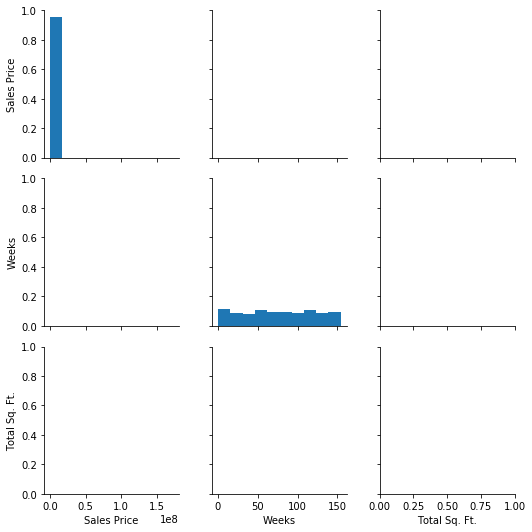

In [809]:
seaborn.pairplot(df[['Sales Price','Weeks','Total Sq. Ft.']])

In [797]:
type((df['Last Sold'].max() - df['Last Sold'].min()).days)

int

## Investigate DataFrame:
- Do overall stats using describe
- Groupby zipcodes and do stats

In [810]:
df.describe()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Weeks,Lot Size Sq. Ft.
count,3346.0,3208.0,4236.0,2677.0,3894.0,464.0,3770.0,2850.0,4236.0,2466.0
mean,2.6,3.2,1415660.6,3.1,2190.5,504.6,1957.6,1968.3,75.9,17901.8
std,2.9,3.0,3155168.9,4.2,3256.5,599.9,31.5,26.8,45.1,52839.7
min,1.0,1.0,210.0,1.0,153.0,0.0,1875.0,1899.0,0.0,1.0
25%,1.5,2.0,545000.0,1.0,1141.0,0.0,1930.0,1953.0,37.0,4683.0
50%,2.0,3.0,954781.5,2.0,1667.5,518.0,1959.0,1971.0,75.0,7169.5
75%,3.0,4.0,1595000.0,3.0,2404.8,800.2,1980.0,1987.0,115.0,12196.8
max,59.0,59.0,172500000.0,31.0,141498.0,10000.0,2016.0,2018.0,154.0,702622.8


In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 0 to 4892
Data columns (total 15 columns):
Baths                 3346 non-null float64
Beds                  3208 non-null float64
County                4236 non-null object
Last Sold             4236 non-null datetime64[ns]
Sales Price           4236 non-null float64
Stories               2677 non-null float64
Style                 4236 non-null object
Total Sq. Ft.         3894 non-null float64
Unfinished Sq. Ft.    464 non-null float64
Year Built            3770 non-null float64
Year Renovated        2850 non-null float64
Zip Code              4236 non-null object
rURL                  4236 non-null object
Weeks                 4236 non-null int64
Lot Size Sq. Ft.      2466 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memory usage: 689.5+ KB


In [689]:
group = df.groupby(['Style']).agg(['mean','std','sem'])
group

Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [690]:
df.groupby(['Style']).agg(['mean','std','sem'])



Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [691]:
df['Style'].unique()

array(['Multi-Family (2-4 Unit)', 'Single Family Residential',
       'Condo/Co-op', 'Multi-Family (5+ Unit)', 'Townhouse'], dtype=object)

In [692]:
df['Style'].nunique()

5

In [695]:
df['Style'].value_counts()

Single Family Residential    2016
Condo/Co-op                  1613
Multi-Family (2-4 Unit)       309
Townhouse                     247
Multi-Family (5+ Unit)        155
Name: Style, dtype: int64

In [701]:
df = df[df['Sales Price']<25000000]

In [702]:
df.groupby(['Style']).mean()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.
Style,,,,,,,,,
Condo/Co-op,1.9,1.9,1135901.4,7.4,1228.2,72.6,1973.7,1981.7,14610.0
Multi-Family (2-4 Unit),4.3,6.0,1632218.3,2.2,3245.0,243.0,1929.6,1936.0,5718.6
Multi-Family (5+ Unit),11.5,14.0,3496519.8,3.4,7568.7,10000.0,1938.2,1963.7,6666.5
Single Family Residential,2.2,3.2,1349915.3,1.4,2228.1,540.8,1950.2,1963.6,15918.6
Townhouse,2.6,2.4,1135429.3,2.3,1679.6,0.0,1982.2,1984.1,65077.5


In [713]:
df['log Sales Price'] = df['Sales Price'].map(np.log10)

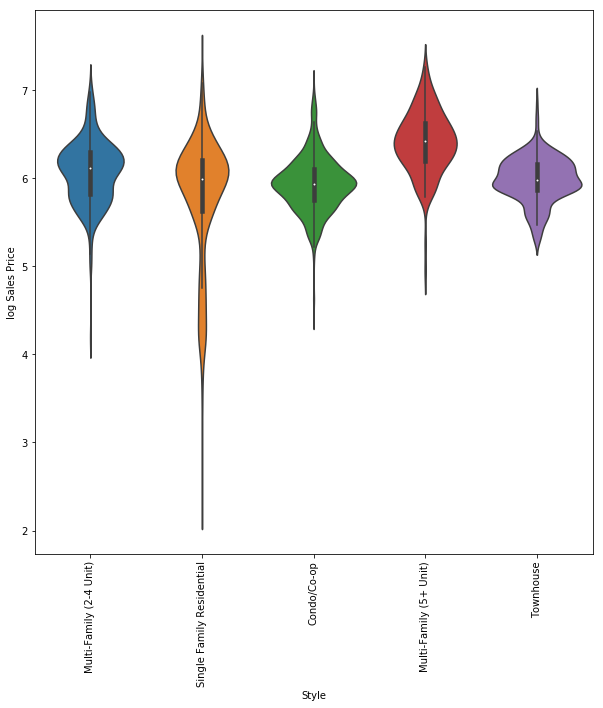

In [716]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.violinplot(x="Style", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

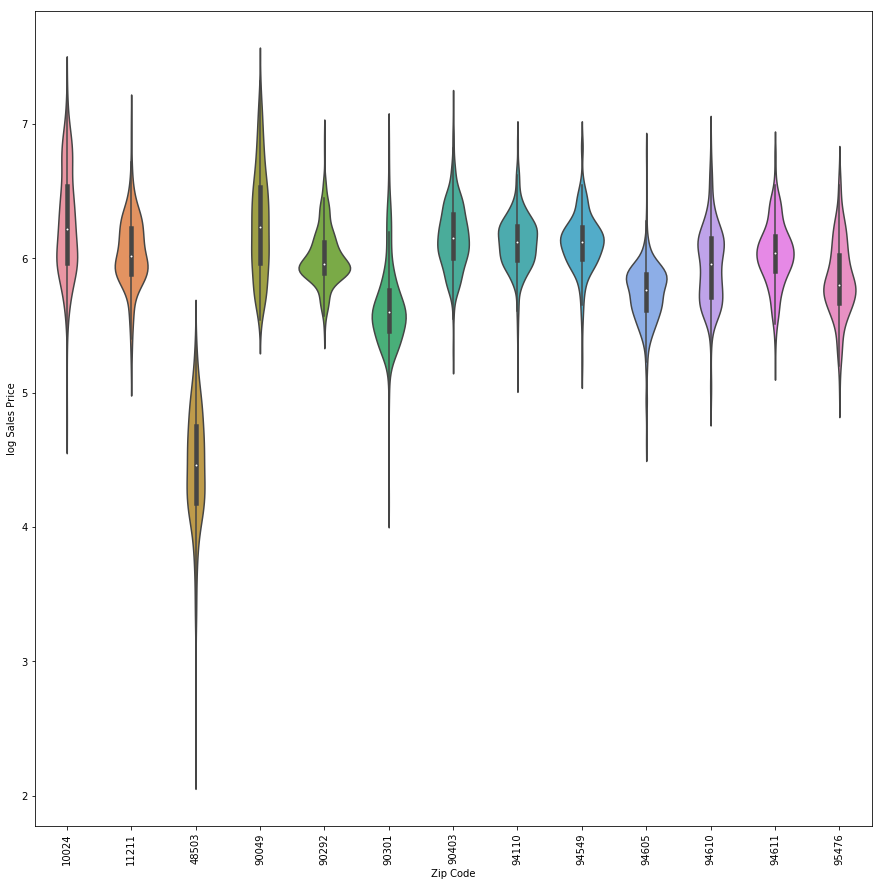

In [715]:
fig, ax = plt.subplots(figsize=(15,15))
seaborn.violinplot(x="Zip Code", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

In [743]:
df.corr()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.,log Sales Price
Baths,1.0,0.9,0.5,0.1,0.8,0.5,0.1,0.1,0.0,0.3
Beds,0.9,1.0,0.4,0.1,0.8,0.1,-0.0,-0.0,-0.0,0.2
Sales Price,0.5,0.4,1.0,0.1,0.6,-0.2,-0.0,0.1,0.1,0.7
Stories,0.1,0.1,0.1,1.0,-0.1,0.3,0.1,0.1,-0.1,0.1
Total Sq. Ft.,0.8,0.8,0.6,-0.1,1.0,0.8,-0.1,0.0,0.0,0.3
Unfinished Sq. Ft.,0.5,0.1,-0.2,0.3,0.8,1.0,-0.2,0.1,-0.0,-0.4
Year Built,0.1,-0.0,-0.0,0.1,-0.1,-0.2,1.0,0.8,0.2,0.1
Year Renovated,0.1,-0.0,0.1,0.1,0.0,0.1,0.8,1.0,0.2,0.1
Lot Size Sq. Ft.,0.0,-0.0,0.1,-0.1,0.0,-0.0,0.2,0.2,1.0,0.1
log Sales Price,0.3,0.2,0.7,0.1,0.3,-0.4,0.1,0.1,0.1,1.0


In [770]:
from datetime import datetime
(df['Last Sold'] > datetime.strptime('2014-05-01', '%Y-%m-%d')).value_counts()

True     4303
False      35
Name: Last Sold, dtype: int64

## Feature Engineering:


#TODO: break out a `homepricemodels.py` script. Accepts a clean/readable data frame. Creates models, analyses, plots for EDA as well as model assessment.
- Feature Engineering functions incl.:
    - add column of `Month`
    - add columns of `Year`
    - Diagnostic plots: plot bar/hist of occurences of `Month`
    - develop grouping/function of `Season` that captures On and Off seasons?

#TODO: plan a datastructure for keeping models (dependent on redfin.py):
- Create a dict of dataframes, one df for each model: `df_dict`
- Create a dict of models, one `OLS` for each df in: `model_dict` Same keys as df_dict?
- Create plot functions that work for each model: predicted vs actual; residuals, 

### Linear Regression and Train/Test Split challenges

Ideally, try these with your own data! (Alternatively, there is the
`2013_movies.csv` data set.)

#### Challenge 1

Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

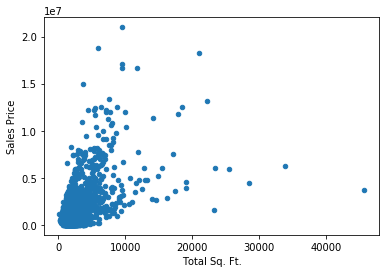

In [724]:
df[['Total Sq. Ft.','Sales Price']].plot(x='Total Sq. Ft.',y='Sales Price',kind='scatter')

Int64Index([   0,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4882, 4883, 4884, 4885, 4887, 4888, 4889, 4890, 4891, 4892],
           dtype='int64', length=4338)

In [750]:
import statsmodels.api as sm

Y = df['Sales Price']

X = pd.Series(1, index=df['Sales Price'].index)

model = sm.OLS(X,Y).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     3070.
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:09:49   Log-Likelihood:                -4994.5
No. Observations:                4338   AIC:                             9991.
Df Residuals:                    4337   BIC:                             9997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Sales Price  3.061e-07   5.52e-09     55.406      0.000    2.95e-07    3.17e-07
==============================================================================
Omnibus:                     4000.105   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168997.615
Skew:                          -4.404   Prob(JB):                         0.00
Kurtosis:                      32.282   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model.predict(1000)

In [738]:
df['Sales Price'].mean()

1353944.7113877363

#### Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [751]:
X = df['Total Sq. Ft.'].
Y = df['Sales Price']

model2 = sm.OLS(X,Y).fit()
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total Sq. Ft.   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Apr 2018   Prob (F-statistic):                nan
Time:                        21:10:12   Log-Likelihood:                    nan
No. Observations:                4338   AIC:                               nan
Df Residuals:                    4337   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Sales Price        nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""





#### Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

#### Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

#### Challenge 5

Fitting and checking predictions on the exact same data set can be
misleading. Divide your data into two sets: a training and a test set
(roughly 75% training, 25% test is a fine split). Fit a model on the
training set, check the predictions (by plotting versus actual values)
in the test set.